# STARmap

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.metrics import *
from sklearn.metrics.cluster import adjusted_rand_score


In [3]:
import BINARY

In [4]:
import pysodb
sodb = pysodb.SODB()

In [5]:
adata_dict = sodb.load_dataset('Dataset11_MS_raw')
adata_raw = list(adata_dict.values())[0]

load experiment[Dataset11] in dataset[Dataset11_MS_raw]


In [6]:
adata_raw

AnnData object with n_obs × n_vars = 3190 × 166
    obs: 'ct', 'gt', 'slice_id', 'batch'
    uns: 'moranI', 'spatial_neighbors'
    obsm: 'spatial'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [7]:
adata = BINARY.clean_adata(adata_raw, save_obs=['gt', 'slice_id'])

In [8]:
adata 

AnnData object with n_obs × n_vars = 3190 × 166
    obs: 'gt', 'slice_id'
    obsm: 'spatial'

In [9]:
adata = BINARY.Count2Binary(adata)

In [10]:
adata.var_names_make_unique()

In [11]:
BINARY.Mutil_Construct_Spatial_Graph(adata, 
                                     use_method='KNN', 
                                     cutoff=14, 
                                     obs_key='slice_id', 
                                     use_list=None)

------Constructing spatial graph...------
The graph contains 14686 edges, 1049 cells.
14.0000 neighbors per cell on average.
------Constructing spatial graph...------
The graph contains 14742 edges, 1053 cells.
14.0000 neighbors per cell on average.
------Constructing spatial graph...------
The graph contains 15232 edges, 1088 cells.
14.0000 neighbors per cell on average.


AnnData object with n_obs × n_vars = 3190 × 166
    obs: 'gt', 'slice_id'
    uns: 'Spatial_Net'
    obsm: 'spatial'

In [12]:
section_list = np.unique(adata.obs['slice_id'])
section_list

array(['BZ14', 'BZ5', 'BZ9'], dtype=object)

In [13]:
adata

AnnData object with n_obs × n_vars = 3190 × 166
    obs: 'gt', 'slice_id'
    uns: 'Spatial_Net'
    obsm: 'spatial'

In [14]:
adata = BINARY.train_BINARY(adata, pos_weight= 10, device = 'cuda:0')

Size of Input:  (3190, 166)


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:05<00:00, 182.38it/s]


In [15]:
sc.pp.neighbors(adata, use_rep='BINARY')
sc.tl.umap(adata)

In [16]:
adata = BINARY.mclust_R(adata, used_obsm='BINARY', num_cluster=4)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


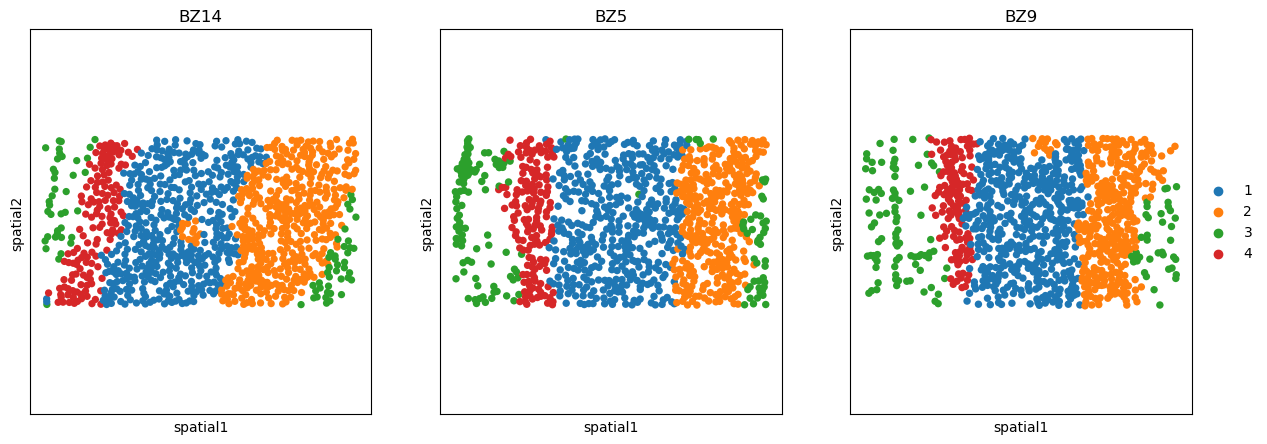

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
it=0
for section_id in section_list:
    if it == 2:
        ax = sc.pl.embedding(adata[adata.obs['slice_id']==section_id], basis='spatial', ax=axs[it],
                      color=["mclust"], title=section_id, show=False)
        ax.axis('equal')
    else:
        ax = sc.pl.embedding(adata[adata.obs['slice_id']==section_id], basis='spatial', ax=axs[it], legend_loc=None,
                      color=["mclust"], title=section_id, show=False)
        ax.axis('equal')
    it+=1

In [18]:
from sklearn.metrics.cluster import adjusted_rand_score
for section_id in section_list:
    temp_adata = adata[adata.obs['slice_id']==section_id]
    temp_obs = temp_adata.obs.dropna()
    temp_ARI = adjusted_rand_score(temp_obs['mclust'], temp_obs['gt'])
    print('ARI of section ID %s: %.3f' %(section_id, temp_ARI))

ARI of section ID BZ14: 0.770
ARI of section ID BZ5: 0.778
ARI of section ID BZ9: 0.731


In [19]:
from sklearn.metrics import *
for section_id in section_list:
    temp_adata = adata[adata.obs['slice_id']==section_id]
    temp_obs = temp_adata.obs.dropna()
    temp_NMI = normalized_mutual_info_score(temp_obs['mclust'], temp_obs['gt'])
    print('NMI of section ID %s: %.3f' %(section_id, temp_NMI))

NMI of section ID BZ14: 0.706
NMI of section ID BZ5: 0.731
NMI of section ID BZ9: 0.682


In [20]:
adata = BINARY.Multi_Refine_label(adata, 
                                  radius=50, 
                                  key='mclust', 
                                  add_key='domain', 
                                  obs_key='slice_id')


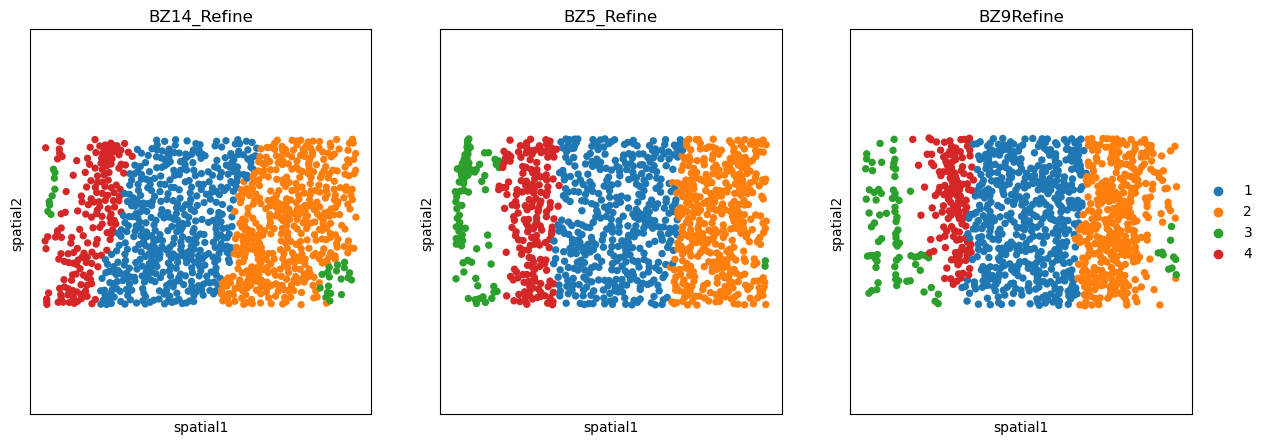

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
it=0
for section_id in section_list:
    if it == 2:
        ax = sc.pl.embedding(adata[adata.obs['slice_id']==section_id], basis='spatial', ax=axs[it],
                      color=["domain"], title=section_id+'Refine', show=False)
        ax.axis('equal')
    else:
        ax = sc.pl.embedding(adata[adata.obs['slice_id']==section_id], basis='spatial', ax=axs[it], legend_loc=None,
                      color=["domain"], title=section_id+'_Refine', show=False)
        ax.axis('equal')
    it+=1

In [22]:
from sklearn.metrics.cluster import adjusted_rand_score
for section_id in section_list:
    temp_adata = adata[adata.obs['slice_id']==section_id]
    temp_obs = temp_adata.obs.dropna()
    temp_ARI = adjusted_rand_score(temp_obs['domain'], temp_obs['gt'])
    print('ARI_Refine of section ID %s: %.3f' %(section_id, temp_ARI))

ARI_Refine of section ID BZ14: 0.851
ARI_Refine of section ID BZ5: 0.848
ARI_Refine of section ID BZ9: 0.797


In [23]:
from sklearn.metrics import *
for section_id in section_list:
    temp_adata = adata[adata.obs['slice_id']==section_id]
    temp_obs = temp_adata.obs.dropna()
    temp_NMI = normalized_mutual_info_score(temp_obs['domain'], temp_obs['gt'])
    print('NMI_Refine of section ID %s: %.3f' %(section_id, temp_NMI))

NMI_Refine of section ID BZ14: 0.781
NMI_Refine of section ID BZ5: 0.845
NMI_Refine of section ID BZ9: 0.745
